# LegacyHalos Surface Brightness Profiles

This notebook demonstrates--using a handful of galaxies as examples--how we measure and model the surface brightness profiles of the central galaxies in our sample.  

We use Michele Cappellari's [mge_fit_sectors](http://purl.org/cappellari/software) software to measure the azimuthally averaged surface-brightness profiles and fit various parameteric models to the data to determine the sizes and integrated fluxes of the galaxies in our sample.

We fit the complete sample using the script legacyhalos.legacyhalos_sbprofiles and generate QAplots from the output using legacyhalos.qaplots_legacyhalos_sbprofiles.

### Installing mge_fit_sectors

To install mge_fit_sectors we downloaded the [2017-07-08 tarball] (give the link!), unpacked its contents to a new **/path/to/mge_2017_07_28/mge** directory and added the top-level directory to our PYTHONPATH:

```python
export PYTHONPATH=/path/to/mge_2017_07_28:$PYTHONPATH
```
We also had to change line 274 in **mge_fit_sectors** to
```python
  from mge.cap_mpfit import mpfit
```
in order for the minimization algorithm to be imported successfully.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
from legacyhalos.io import coadds_dir, findfile

In [3]:
from mge.find_galaxy import find_galaxy
from mge.sectors_photometry import sectors_photometry
from mge.mge_fit_sectors import mge_fit_sectors as fit_sectors
from mge.mge_print_contours import mge_print_contours as print_contours

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [5]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')
coaddsdir = os.path.join(legacyhalos_dir, 'coadds')

In [6]:
pixscale = 0.262 # [arcsec/pix] - assume DECam

In [7]:
findfile('upennparent')

'/Users/ioannis/research/projects/legacyhalos/legacyhalos-upenn-parent.fits'

In [8]:
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-upenn-parent.fits')
parent = Table(fits.getdata(parentfile, extname='LSPHOT'))
parent[:2]

RELEASE,BRICKID,BRICKNAME,OBJID,BRICK_PRIMARY,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,BX,BY,DCHISQ [5],EBV,MJD_MIN,MJD_MAX,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,APFLUX_U [8],APFLUX_G [8],APFLUX_R [8],APFLUX_I [8],APFLUX_Z [8],APFLUX_Y [8],APFLUX_RESID_U [8],APFLUX_RESID_G [8],APFLUX_RESID_R [8],APFLUX_RESID_I [8],APFLUX_RESID_Z [8],APFLUX_RESID_Y [8],APFLUX_IVAR_U [8],APFLUX_IVAR_G [8],APFLUX_IVAR_R [8],APFLUX_IVAR_I [8],APFLUX_IVAR_Z [8],APFLUX_IVAR_Y [8],MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,LC_FLUX_W1 [7],LC_FLUX_W2 [7],LC_FLUX_IVAR_W1 [7],LC_FLUX_IVAR_W2 [7],LC_NOBS_W1 [7],LC_NOBS_W2 [7],LC_FRACFLUX_W1 [7],LC_FRACFLUX_W2 [7],LC_RCHISQ_W1 [7],LC_RCHISQ_W2 [7],LC_MJD_W1 [7],LC_MJD_W2 [7],FRACDEV,FRACDEV_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR
int16,int32,str8,int32,bool,str4,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str8,float32,float32,float32,float32,int16,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
5000,350049,2407p032,4026,True,DEV,240.829131417,3.27905301114,7.39469e+12,7.82942e+12,155.908,2198.8,805429.0 .. 1.22505e+06,0.131241,56404.2671927,57603.9668753,0.0,56.6587,228.5,0.0,562.889,0.0,749.382,531.548,222.894,1347.96,0.0,38.2828,13.3693,0.0,2.9326,0.0,0.491633,0.113302,0.00035686,1.05384e-05,0.0 .. 0.0,1.96082 .. 40.9147,8.27318 .. 157.024,0.0 .. 0.0,21.4745 .. 378.622,0.0 .. 0.0,0.0 .. 0.0,0.0419421 .. 0.103721,0.529276 .. -3.39581,0.0 .. 0.0,1.64001 .. -13.2345,0.0 .. 0.0,0.0 .. 0.0,10360.2 .. 52.8579,5044.23 .. 25.7359,0.0 .. 0.0,687.468 .. 3.21099,0.0 .. 0.0,0.616987,0.678072,0.769742,0.824946,0.863827,0.879313,0.978004,0.986434,0.997091,0.998901,0,3,3,0,4,0,84,84,13,13,0.0,1.41654,3.04899,0.0,5.20142,0.0,14.8612,1.81925,0.872876,0.0816663,0.0,0.0486396,0.0413673,0.0,0.03764

In [9]:
gal = parent[0]

In [10]:
suffix = '{0:05d}'.format(gal['OBJID'])
imfile = os.path.join(coaddsdir, suffix, '{}-image-r.fits.fz'.format(suffix))
modelfile = os.path.join(coaddsdir, suffix, '{}-model-r.fits.fz'.format(suffix))
img, hdr = fits.getdata(imfile, ext=0, header=True)
model = fits.getdata(modelfile, ext=0)

In [11]:
residimg = img - model

 Pixels used: 2242
 Peak Img[j, k]: 76 76
 Mean (j, k): 76.37 76.21
 Theta (deg): 125.2
 Astro PA (deg): 144.8
 Eps: 0.043
 Major axis (pix): 35.8


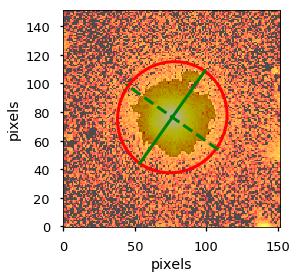

In [12]:
ff = find_galaxy(residimg, plot=True)

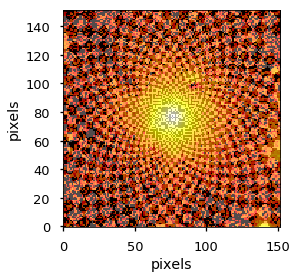

In [13]:
ss = sectors_photometry(residimg, ff.eps, ff.theta, ff.xpeak, ff.ypeak, badpixels=None,
                           n_sectors=19, mask=None, minlevel=0, plot=True)

(32, 22)

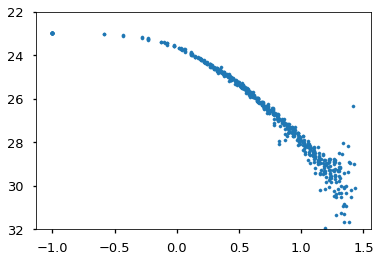

In [14]:
fig, ax = plt.subplots()
ax.scatter(np.log10(ss.radius*pixscale), 22.5-2.5*np.log10(ss.counts), s=10)
ax.set_ylim(32, 22)

Iteration: 1  chi2: 98.92  Nonzero: 8/12
Iteration: 11  chi2: 90.61  Nonzero: 7/12
Nonzero Gaussians: 7/12
Eliminating not useful Gaussians...
ngauss: 6           chi2: 90.6
ngauss: 5           chi2: 90.6
ngauss: 4           chi2: 90.7
Starting nonlinear fit...
Iteration: 1  chi2: 90.69  Nonzero: 4/4
Nonzero Gaussians: 4/4
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 0.29 seconds
  Total Iterations:  11
 Nonzero Gaussians:  4
  Unused Gaussians:  8
 Sectors used in the fit:  19
 Total number of points fitted:  589
 Chi2: 90.63 
 STDEV: 0.3608 
 MEANABSDEV: 0.2245 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
      23.0241      2.92297            1
      62.6198      7.66608            1
      78.5927      20.4024            1
      12.1159      39.5216            1
++++++++++++++++++++++++++++++++++++++++++++


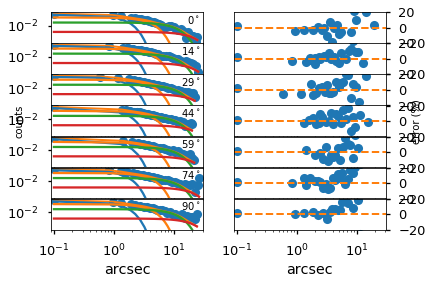

In [15]:
pp = fit_sectors(ss.radius, ss.angle, ss.counts, ff.eps,
                 ngauss=12, negative=False, sigmaPSF=0, normPSF=1, scale=pixscale,
                 rbounds=None, qbounds=None, linear=False, quiet=False,
                 outer_slope=4, bulge_disk=False, sol=0, plot=True)

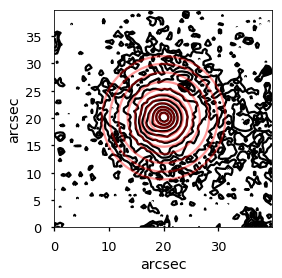

In [ ]:
_ = print_contours(residimg, ff.pa, ff.xpeak, ff.ypeak, pp.sol, 
                   binning=2, normpsf=1, magrange=6, mask=None, 
                   scale=pixscale, sigmapsf=0)